# Facial Emotion Recognition

## 01_preprocessing
얼굴감지: kaggle https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data  
멀티모달: github https://github.com/maelfabien/Multimodal-Emotion-Recognition/tree/master/03-Video  

In [1]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 확인
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset 만들기
import keras
from keras.utils import to_categorical

# Detect Face
import cv2
from scipy.ndimage import zoom

# Model
import torch
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import batch_normalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

In [2]:
device = torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

### 데이터 확인

In [3]:
df = pd.read_csv('./data/fer2013.csv')
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [4]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [5]:
# 이미지 픽셀 list로 만들기
df['pixels'] = df['pixels'].apply(lambda pixel: np.fromstring(pixel, sep=' '))
df.head()

,emotion,pixels,Usage
0,0,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63....",Training
1,0,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111...",Training
2,2,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161...",Training
3,4,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20....",Training
4,6,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Training


In [6]:
# train test 나누기
train_df = df[df['Usage']=='Training']
test_df = df[df['Usage']=='PublicTest']
print(train_df.shape)
print(test_df.shape)

(28709, 3)
(3589, 3)


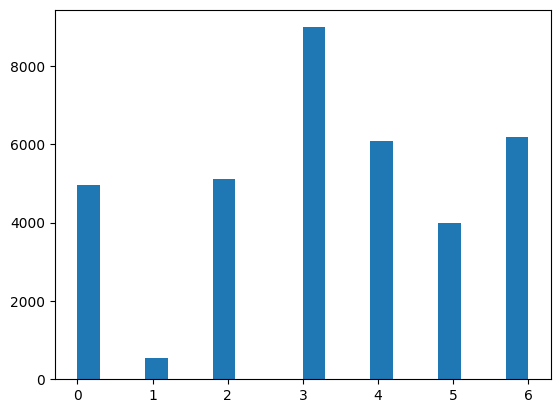

In [7]:
# 전체데이터 감정 라벨링 확인
plt.hist(df['emotion'], bins=20)
plt.show()

In [8]:
emotion = pd.DataFrame({'emotion_no':[0, 1, 2, 3, 4, 5, 6],
                        'emotion_label':['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
                       })
emotion

,emotion_no,emotion_label
0,0,angry
1,1,disgust
2,2,fear
3,3,happy
4,4,sad
5,5,surprise
6,6,neutral


### Dataset 만들기

In [9]:
shape_x = 48
shape_y = 48

In [10]:
# X_train, y_train, X_test, y_test split
X_train = train_df.iloc[:, 1].values # pixles
y_train = train_df.iloc[:, 0].values # emotion

X_test = test_df.iloc[:, 1].values # pixles
y_test = test_df.iloc[:, 0].values # emotion

# 전체데이터
X = df.iloc[:, 1].values # pixles
y = df.iloc[:, 0].values # emotion

In [11]:
print('X_train 확인 - pixels')
X_train

X_train 확인 - pixels


array([array([ 70.,  80.,  82., ..., 106., 109.,  82.]),
       array([151., 150., 147., ..., 193., 183., 184.]),
       array([231., 212., 156., ...,  88., 110., 152.]), ...,
       array([ 74.,  81.,  87., ..., 188., 187., 187.]),
       array([222., 227., 203., ..., 136., 136., 134.]),
       array([195., 199., 205., ...,   6.,  15.,  38.])], dtype=object)

In [12]:
print('y_train 확인 - emotion')
y_train

y_train 확인 - emotion


array([0, 0, 2, ..., 4, 0, 4])

In [13]:
# array([array([....])]) 구조를 바꾸기 위한 np.vstack
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
X = np.vstack(X)

In [14]:
print('X_train 확인')
X_train

X_train 확인


array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.],
       ...,
       [ 74.,  81.,  87., ..., 188., 187., 187.],
       [222., 227., 203., ..., 136., 136., 134.],
       [195., 199., 205., ...,   6.,  15.,  38.]])

In [15]:
# 4차원 데이터셋 만들기 (데이터개수, x축, y축, rgb)
X_train_ds = np.reshape(X_train, (X_train.shape[0], shape_x, shape_y, 1))
y_train_ds = np.reshape(y_train, (y_train.shape[0], 1))

X_test_ds = np.reshape(X_test, (X_test.shape[0], shape_x, shape_y, 1))
y_test_ds = np.reshape(y_test, (y_test.shape[0], 1))

print(X_train_ds.shape, y_train_ds.shape)
print(X_test_ds.shape, y_test_ds.shape)

(28709, 48, 48, 1) (28709, 1)
(3589, 48, 48, 1) (3589, 1)


In [16]:
# 데이터타입 float로 변경
train_data = X_train_ds.astype('float32')
test_data = X_test_ds.astype('float32')

# 스케일링
train_data /= 225
test_data /= 225

# y데이터 원핫인코딩
train_labels_onehot = to_categorical(y_train_ds)
test_labels_onehot = to_categorical(y_test_ds)

In [17]:
# input_shape 설정
n_rows, n_cols, n_dims = X_train_ds.shape[1:]
input_shape = (n_rows, n_cols, n_dims)
print(input_shape)

(48, 48, 1)


In [18]:
def get_label(argument):
    labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
    return(labels.get(argument, 'Invalid emotion'))

Text(0.5, 1.0, 'Ground Truth : happy')

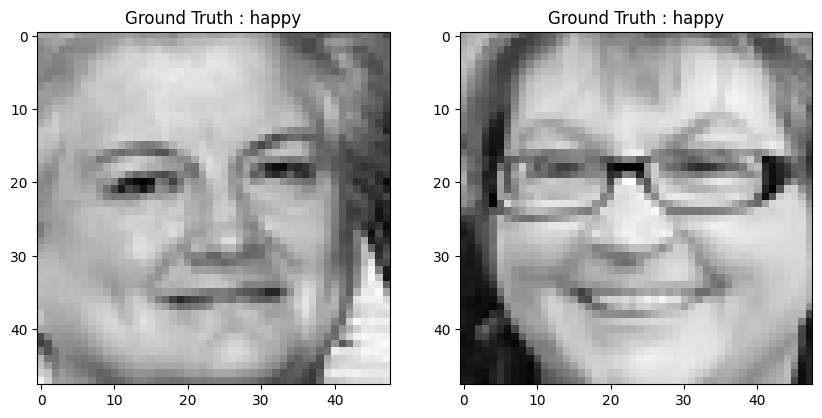

In [19]:
plt.figure(figsize=[10,5])

# Train data 중 100번째 이미지
n=100

plt.subplot(121)
plt.imshow(np.squeeze(X_train_ds[n,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[n]))))

# Test data 중 100번째 이미지
plt.subplot(122)
plt.imshow(np.squeeze(X_test_ds[n,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[n]))))

### Detect Faces
openCV의 cascade 사용 : haarcascade_frontalface_default.xml

In [5]:
# 전체 이미지에서 얼굴을 찾아내는 함수
def detect_face(frame):
    
    # cascade pre-trained 모델 불러오기
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # RGB를 gray scale로 바꾸기
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # cascade 멀티스케일 분류
    detected_faces = face_cascade.detectMultiScale(gray,
                                                   scaleFactor = 1.1,
                                                   minNeighbors = 6,
                                                   minSize = (shape_x, shape_y),
                                                   flags = cv2.CASCADE_SCALE_IMAGE
                                                  )
    
    coord = []
    for x, y, w, h in detected_faces:
        if w > 100:
            sub_img = frame[y:y+h, x:x+w]
            coord.append([x, y, w, h])
            
    return gray, detected_faces, coord

In [6]:
# 전체 이미지에서 찾아낸 얼굴을 추출하는 함수
def extract_face_features(gray, detected_faces, coord, offset_coefficients=(0.075, 0.05)):
    new_face = []
    for det in detected_faces:
        
        # 얼굴로 감지된 영역
        x, y, w, h = det
        
        # 이미지 경계값 받기
        horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
        vertical_offset = np.int(np.floor(offset_coefficients[1] * h))
        
        # gray scacle 에서 해당 위치 가져오기
        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
        
        # 얼굴 이미지만 확대
        new_extracted_face = zoom(extracted_face, (shape_x/extracted_face.shape[0], shape_y/extracted_face.shape[1]))
        new_extracted_face = new_extracted_face.astype(np.float32)
        new_extracted_face /= float(new_extracted_face.max()) # sacled
        new_face.append(new_extracted_face)
        
    return new_face

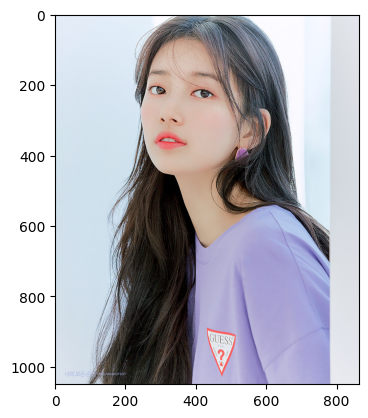

In [22]:
suzy = cv2.imread('./data/e_neutral.jpeg')
plt.imshow(cv2.cvtColor(suzy, cv2.COLOR_BGR2RGB))

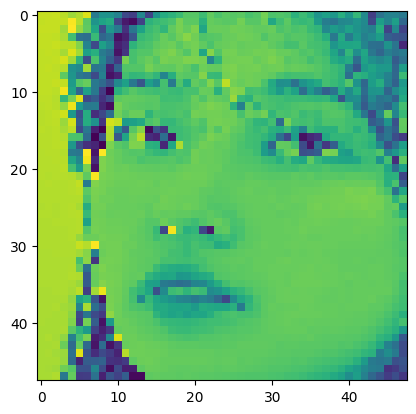

In [23]:
gray, detected_faces, coord = detect_face(suzy)
face_zoom = extract_face_features(gray, detected_faces, coord)
plt.imshow(face_zoom[0])

#### 얼굴만 감지해서 확대추출까지 성공

## 02_model
tensorflow의 keras로 진행

### 모델 구축

In [24]:
def simple_model():
    model = Sequential()
    
    # Input layer
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    
    # Add layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    # Flatten
    model.add(Flatten())
    
    # Fully connected layer
    model.add(Dense(512, activation='relu'))
    
    # Output layer : n_classes=7
    model.add(Dense(7, activation='softmax'))
    
    return model

In [25]:
model = simple_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 64)        36928     
                                                        

In [26]:
# 각 레이어마다 어떻게 변화하는지 시각화

# 마지막 Dense 레이어 2개를 제외한 레이어별 out 담기 
layer_outputs = [layer.output for layer in model.layers[:12]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [27]:
# 시각화 할 때 어떤 레이어인지 확인할 수 있도록 레이어 이름 담기
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name)

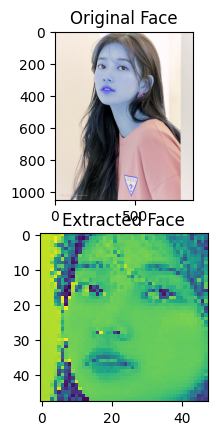

In [28]:
# 수지 얼굴 이미지 가져오기
suzy = cv2.imread('./data/e_neutral.jpeg')
gray, detected_faces, coord = detect_face(suzy)
face_zoom = extract_face_features(gray, detected_faces, coord)
face = face_zoom[0]

plt.subplot(211)
plt.title("Original Face")
plt.imshow(suzy)

plt.subplot(212)
plt.title("Extracted Face")
plt.imshow(face)

plt.show()

1/1 [==============================] - 0s 32ms/step


2023-05-22 11:35:48.874649: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


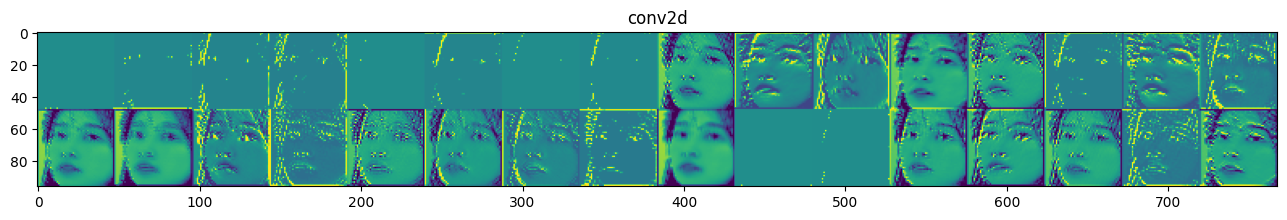

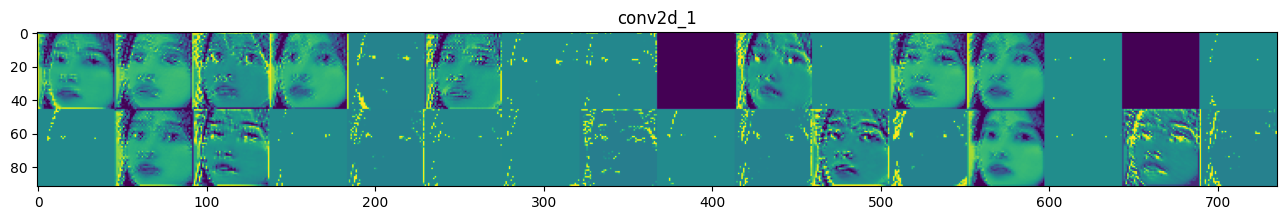

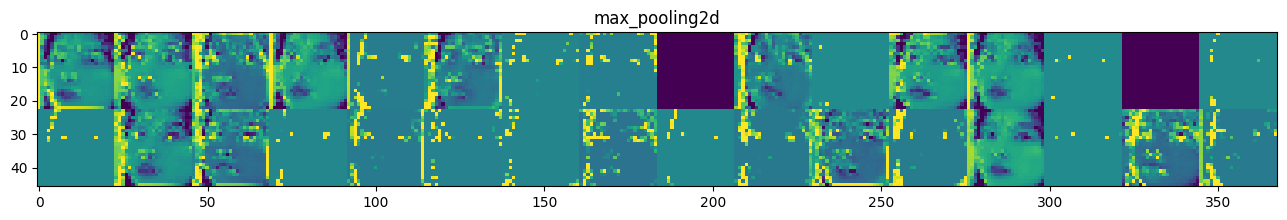

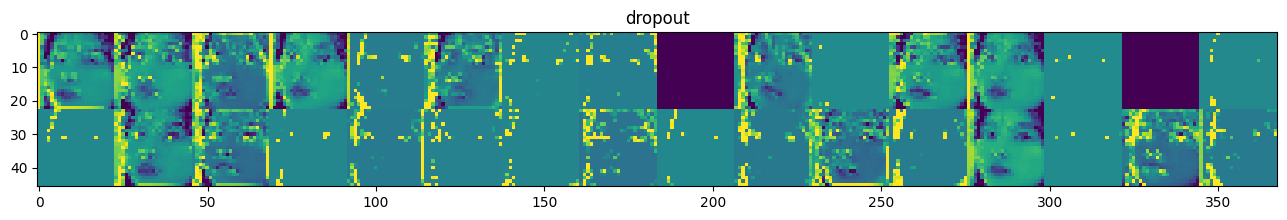

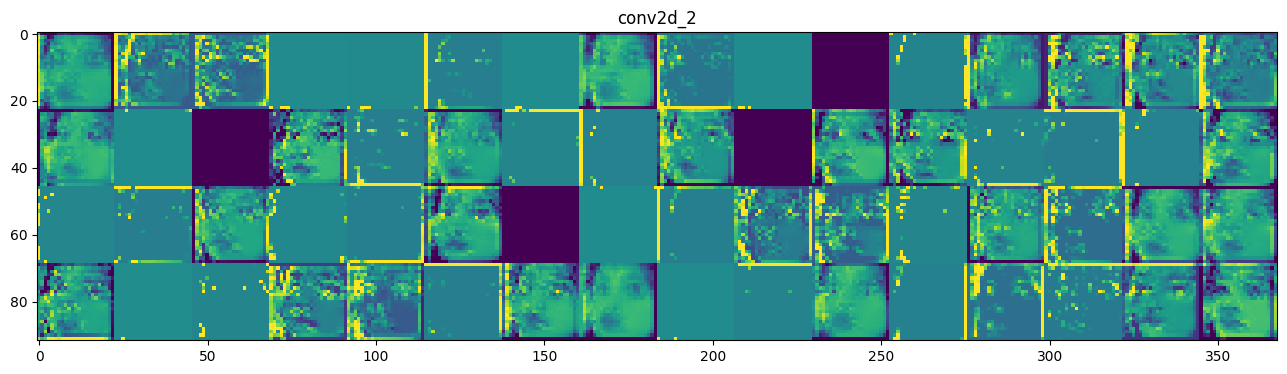

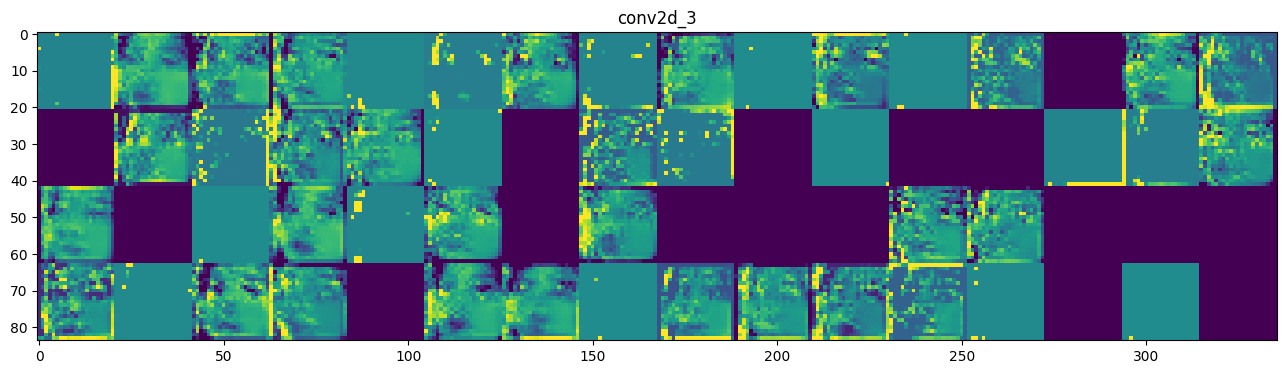

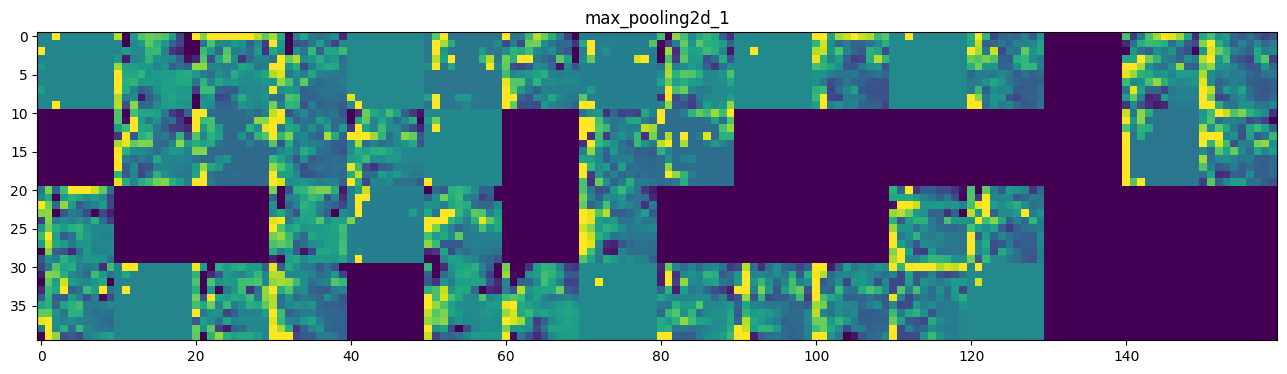

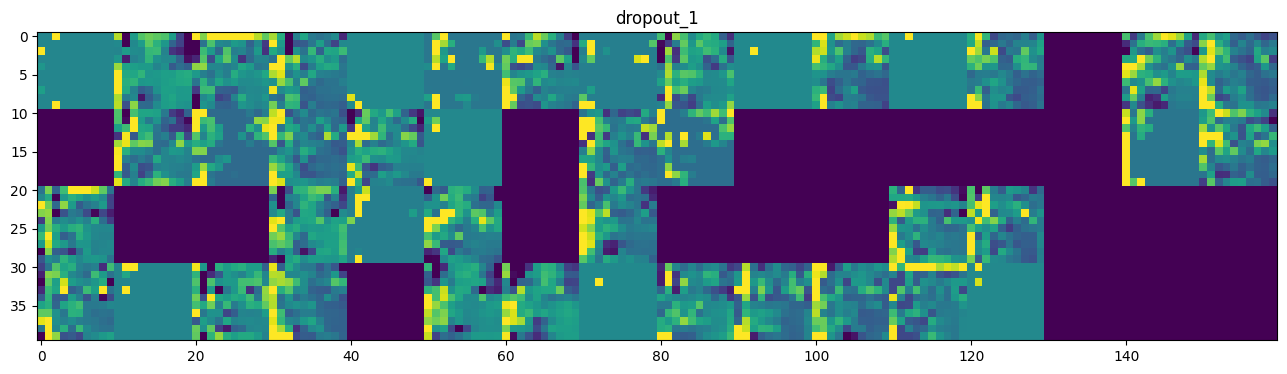

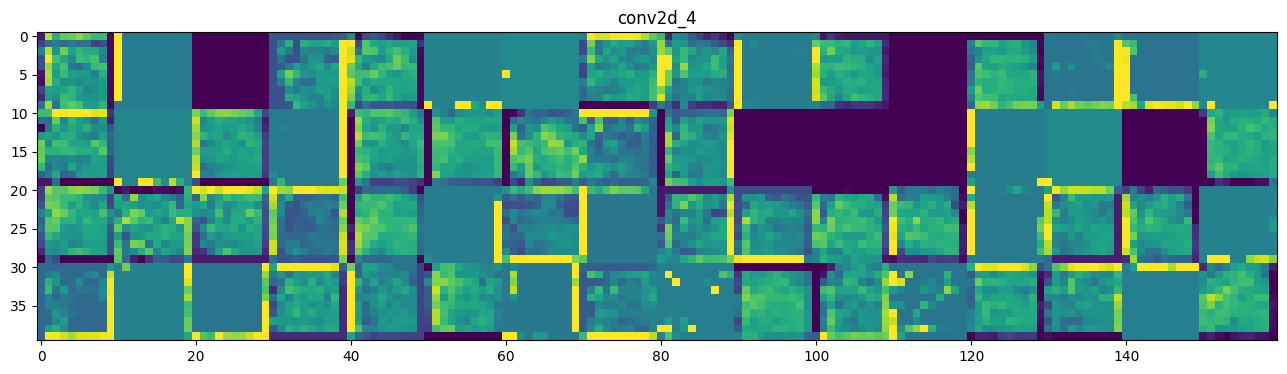

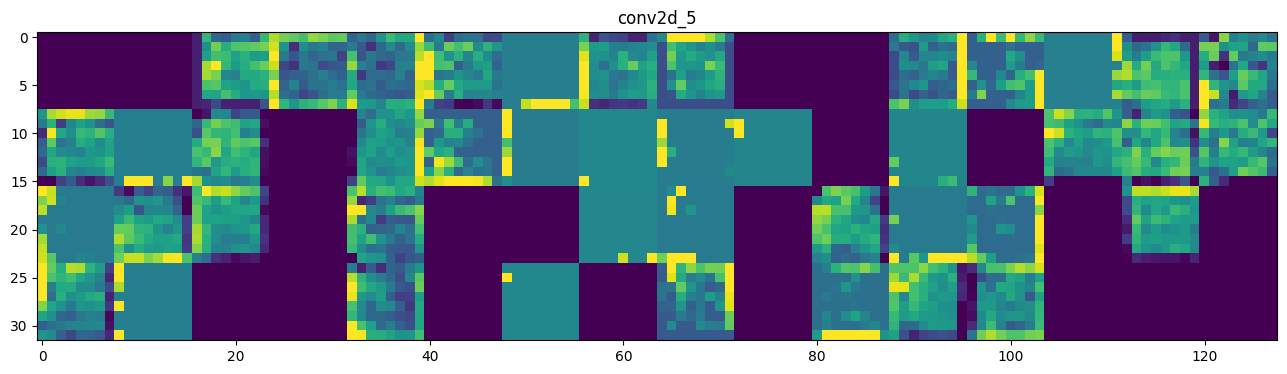

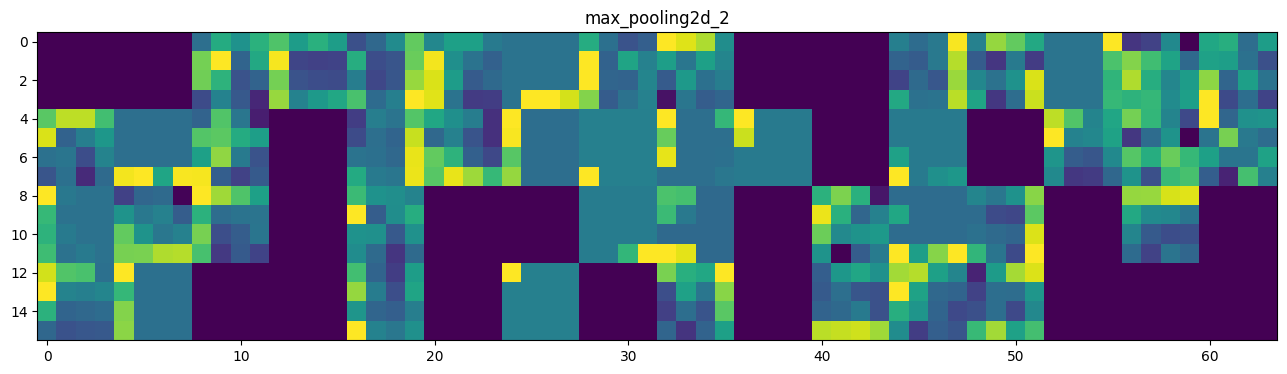

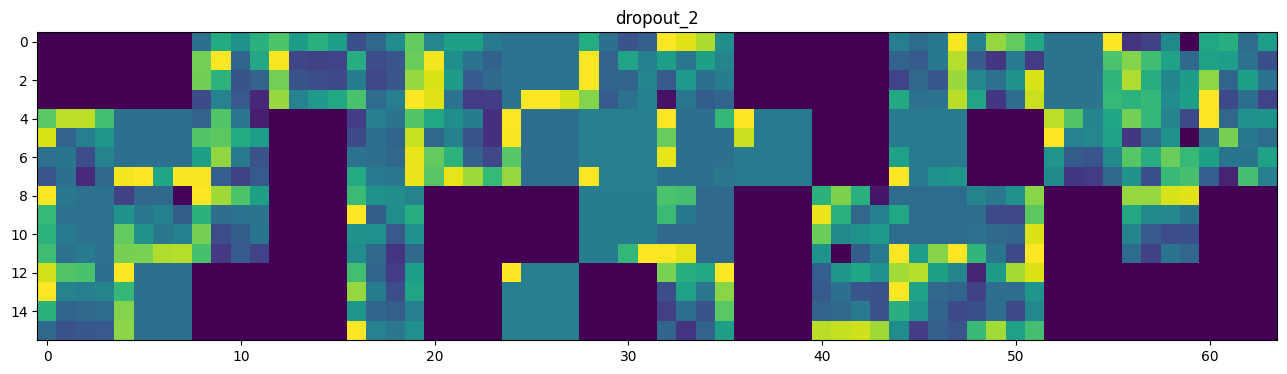

In [29]:
# 수지 얼굴 모델에 넣어서 모델이 어떻게 작동하는지 시각화
to_predict = np.reshape(face.flatten(), (1,48,48,1))
res = model.predict(to_predict)
activations = activation_model.predict(to_predict)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### 모델 학습

In [30]:
# 이미지 데이터 증강
datagen = ImageDataGenerator(zoom_range=0.2,          # 랜덤하게 이미지 줌 하는 비율
                             rotation_range=10,       # 램덤하게 이미지 회전하는 비율 (0도~180도)
                             width_shift_range=0.1,   # 랜덤하게 이미지 가로로 이동하는 비율
                             height_shift_range=0.1,  # 랜덤하게 이미지 세로로 이동하는 비율
                             horizontal_flip=True,    # 랜덤하게 이미지 수평 뒤집기
                             vertical_flip=False)     # 랜덤하게 이미지 수직 뒤집기

In [ ]:
# 모델 학습을 위한 파라미터 설정
batch_size = 256
n_epochs = 100
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(datagen.flow(train_data, train_labels_onehot, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(train_data.shape[0]/float(batch_size))),
                              epochs=n_epochs,
                              validation_data=(test_data, test_labels_onehot)
                             )

Epoch 1/100
113/113 [==============================] - 45s 396ms/step - loss: 1.8185 - accuracy: 0.2465 - val_loss: 1.7970 - val_accuracy: 0.2555
Epoch 2/100
113/113 [==============================] - 50s 440ms/step - loss: 1.7606 - accuracy: 0.2756 - val_loss: 1.6892 - val_accuracy: 0.3305
Epoch 3/100
113/113 [==============================] - 50s 441ms/step - loss: 1.6810 - accuracy: 0.3250 - val_loss: 1.5564 - val_accuracy: 0.3906
Epoch 4/100
113/113 [==============================] - 50s 440ms/step - loss: 1.6068 - accuracy: 0.3649 - val_loss: 1.4429 - val_accuracy: 0.4411
Epoch 5/100
113/113 [==============================] - 58s 513ms/step - loss: 1.5202 - accuracy: 0.4108 - val_loss: 1.3694 - val_accuracy: 0.4581
Epoch 6/100
113/113 [==============================] - 59s 525ms/step - loss: 1.4390 - accuracy: 0.4446 - val_loss: 1.3016 - val_accuracy: 0.4985
Epoch 7/100
113/113 [==============================] - 59s 522ms/step - loss: 1.3829 - accuracy: 0.4650 - val_loss: 1.2676 -

#### 모델 평가 Evaluate

In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
model.save('./face_emotion.h5')

## 결과 확인

In [39]:
model = keras.models.load_model('./face_emotion.h5')

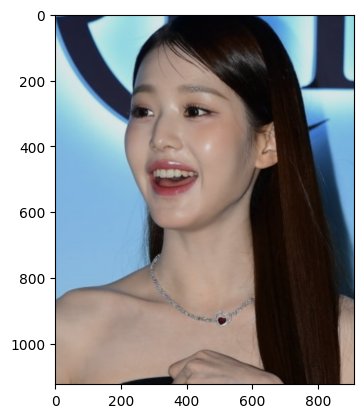

In [54]:
face = cv2.imread('./data/e_happy.png')
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

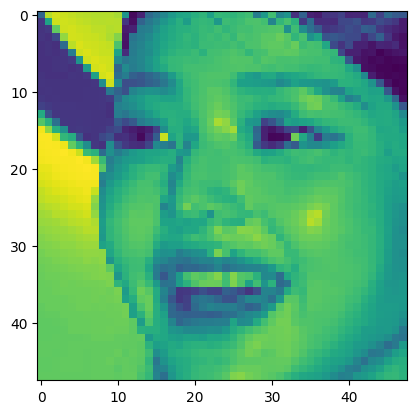

In [41]:
gray, detected_faces, coord = detect_face(face)
face_zoom = extract_face_features(gray, detected_faces, coord)
plt.imshow(face_zoom[0])

In [42]:
input_data = np.reshape(face_zoom[0].flatten(), (1, 48, 48, 1))
output_data = model.predict(input_data)
result = np.argmax(output_data)

1/1 [==============================] - 0s 50ms/step


In [43]:
if result == 0:
    print(result, ':angry')
elif result == 1:
    print(result, ':disgust')
elif result == 2:
    print(result, ':fear')
elif result == 3:
    print(result, ':happy')
elif result == 4:
    print(result, ':sad')
elif result == 5:
    print(result, ':surprise')
elif result == 6:
    print(result, ':neutral')

3 :happy
